In [ ]:
# Some of the packages that need to be installed to run this notebook

# !pip install matplotlib
# !pip install wget
# !pip install pillow
!pip install numpy==1.19.5
# !pip install tensorflow_gpu==2.5.0

### Download of TF2 Object Detection API
https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#general-remarks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import wget
import tarfile
import shutil
import os
import re
from glob import glob
from PIL import Image
import numpy as np
import pickle
from metric_utils import np_iou, overlap_based_on_iou

import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

In [2]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

In [3]:
dst = "malaria/pre-trained-models"
os.makedirs(dst, exist_ok=True)
filename = "ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz"

In [ ]:
urls = ["http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz",
        ]

for url in urls:
    filename = wget.download(url)
    shutil.move(f"./{filename}", dst) # move tar file to folder where contents will be extracted
    
    # extract components from tar file
    with tarfile.open(f"{dst}/{filename}") as tar:
        tar.extractall(path = f"{dst}")

    os.remove(f"{dst}/{filename}") # delete tar file


In [4]:
modelName = filename.replace(".tar.gz","")
print(modelName)

ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8


In [5]:
# Make necessary folders
model_checkpoint_storage = f'malaria/models/{modelName}' # storage folder for training checkpoints
final_model_storage = f'malaria/exported-models/{modelName}' # storage for trained model

for f in [model_checkpoint_storage,final_model_storage]:
    os.makedirs(f, exist_ok=True)

In [ ]:
!python prepDataBb.py --set_type=training # prepares the training data in the format required by TF2 Object Detection API

In [ ]:
!python prepDataBb.py --set_type=test # prepares the test data in the format required by TF2 Object Detection API

In [ ]:
!python prepDataBb2.py # prepares class and bounding box files for custom evaluation

### Command-line Training

##### Pipeline config
Configures the pipeline config file which has model configs such as hyperparameters, optimizer, location to save checkpoints, etc. 

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()

with tf.io.gfile.GFile(f"{dst}/{modelName}/pipeline.config", "r") as f:                                                 
        proto_str = f.read()                                          
        text_format.Merge(proto_str, pipeline_config)

In [ ]:
pipeline_config.model.ssd.num_classes = 6
pipeline_config.model.ssd.freeze_batchnorm = True

pipeline_config.train_config.batch_size = 2
pipeline_config.train_config.num_steps = 12000

pipeline_config.train_config.fine_tune_checkpoint = f"malaria/pre-trained-models/{modelName}/checkpoint/ckpt-0"
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_config.use_bfloat16 = False # if using TPU, set this to True

pipeline_config.train_input_reader.label_map_path = 'malaria/annotations/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[0] = "malaria/annotations/training.record"

pipeline_config.eval_input_reader[0].label_map_path = 'malaria/annotations/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[0] = "malaria/annotations/test.record"

pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.total_steps = pipeline_config.train_config.num_steps

In [ ]:
# Write config                                                                                                                                                                                                     
with tf.io.gfile.GFile(f'malaria/models/{modelName}/pipeline.config', "wb") as f:                                                                                                                                                                                                                       
    f.write(text_format.MessageToString(pipeline_config))

In [ ]:
# Tensorboard - paste in terminal
print(f"tensorboard --logdir=malaria/models/{modelName}")

In [ ]:
# Training script
# Copy paste in terminal

print(f"python model_main_tf2.py \
--model_dir=malaria/models/{modelName} \
--pipeline_config_path=malaria/models/{modelName}/pipeline.config\
      ")

# python model_main_tf2.py `
# --model_dir=malaria/models/efficientdet_d2_coco17_tpu-32 `
# --pipeline_config_path=malaria/models/efficientdet_d2_coco17_tpu-32/pipeline.config

In [ ]:
# 1.17.5 required for model evaluation
!pip install numpy==1.17.5 
# Restart kernel after install

In [ ]:
# Export trained model
# Copy paste in terminal

print(f" \
python ./exporter_main_v2.py \
--input_type image_tensor \
--pipeline_config_path malaria/models/{modelName}/pipeline.config \
--trained_checkpoint_dir malaria/models/{modelName} \
--output_directory malaria/exported-models/{modelName} \
      ")

# python ./exporter_main_v2.py `
# --input_type image_tensor `
# --pipeline_config_path malaria/models/efficientdet_d2_coco17_tpu-32/pipeline.config `
# --trained_checkpoint_dir malaria/models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8 `
# --output_directory malaria/exported-models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8

##### Run inference on trained Model

In [ ]:
# View Prec, Recall, IOU on Eval Data defined in pipeline.config Using COCO Metrics
# Copy paste in terminal

print(f" \
python model_main_tf2.py \
--model_dir=malaria/models/{modelName} \
--pipeline_config_path malaria/models/{modelName}/pipeline.config \
--checkpoint_dir=malaria/models/{modelName} \
      ")

# python model_main_tf2.py `
# --model_dir=malaria/models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8 `
# --pipeline_config_path=malaria/models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config `
# --checkpoint_dir=malaria/models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8

### Custom Model Inference
We want to visualize each image and use custom metrics rather than COCO2017 Dataset metrics

In [6]:
# Make necessary folders
os.makedirs(f"malaria/inference/{modelName}/images",exist_ok=True)
os.makedirs(f"malaria/inference/{modelName}/boxes",exist_ok=True)
os.makedirs(f"malaria/inference/{modelName}/classesAndScores",exist_ok=True)

In [7]:
num_gpus = len(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus)

if num_gpus>0:
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.OneDeviceStrategy(device = "/device:CPU:0")

Num GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
PATH_TO_SAVED_MODEL = f"{final_model_storage}/saved_model"

print('Loading model...', end='')

# Load saved model and build the detection function
with strategy.scope():
    model = tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

Loading model...Done!


##### Load labels

In [9]:
label_map = label_map_util.load_labelmap(os.path.join('malaria/annotations', 'label_map.pbtxt'))
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=6, use_display_name=True) # list of dict
category_index = label_map_util.create_category_index(categories) # creates dict of dict

print(category_index)

{1: {'id': 1, 'name': 'red blood cell'}, 2: {'id': 2, 'name': 'leukocyte'}, 3: {'id': 3, 'name': 'schizont'}, 4: {'id': 4, 'name': 'gametocyte'}, 5: {'id': 5, 'name': 'ring'}, 6: {'id': 6, 'name': 'trophozoite'}}


In [10]:
def process_detection_boxes(boxes, scores, iou_thres = 0.95, conf_thres=-1):
    
    # Delete boxes where IoU >= iou_thres with another box
    iou_rows = overlap_based_on_iou(boxes, scores, iou_thres) # returns dictionary
    
    # Delete boxes with confidence scores below a threshold
    conf_rws = np.argwhere(scores<conf_thres).flatten().tolist() # returns list
    
    return iou_rows, conf_rws
            

##### Output and Visualize Results

Running inference for 1/390: 002f20ad-2ace-499c-9335-c9080bc3e6b5.png


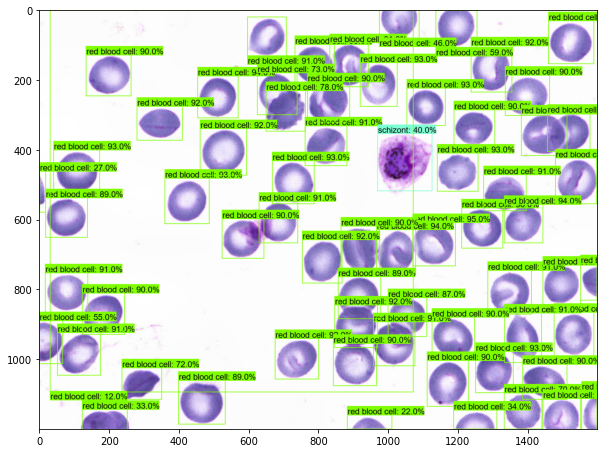

Running inference for 2/390: 003a89b0-a095-417a-8dd6-f408339bbc68.png


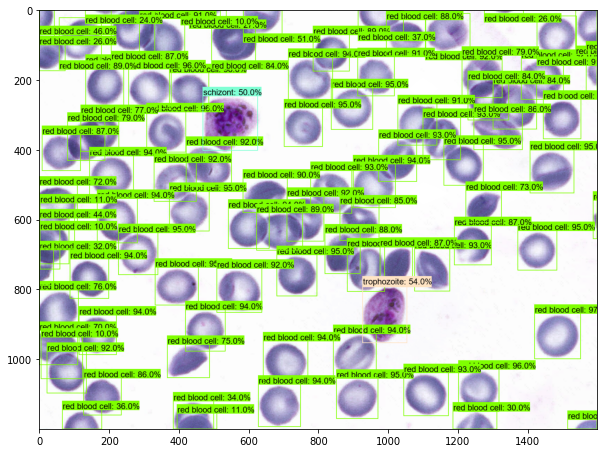

Running inference for 3/390: 003d1cdc-0aec-430b-90e0-f4d82135b1ac.png
Running inference for 4/390: 005e60b6-77b8-458c-b57c-bfe0c7e7df78.png
Running inference for 5/390: 00a02700-2ea2-4590-9e15-ffc9160fd3de.png
Running inference for 6/390: 00c8364b-8c85-4502-bcfe-64736fe76815.png
Running inference for 7/390: 00d04a90-80e5-4bce-9511-1b64eabb7a47.png
Running inference for 8/390: 01b38a56-13eb-447b-89ee-fc21cb40dcc1.png
Running inference for 9/390: 01b99da8-b66b-464b-a7ee-1cadab8db18b.png
Running inference for 10/390: 027ab174-e47a-44f8-b85b-372449eeb7d8.png
Running inference for 11/390: 02ea7aa8-c142-4a3d-939f-e77689741341.png
Running inference for 12/390: 02fb5e19-6f94-4787-bb78-e550a29a3cbd.png
Running inference for 13/390: 030f3421-ed3f-4bf1-8f27-4d02590bffbc.png
Running inference for 14/390: 034c8d57-04d5-4786-93a4-6ae8fde2c258.png
Running inference for 15/390: 035f6c4b-0897-46ab-9c3b-5f3b0feff043.png
Running inference for 16/390: 036e008f-07a1-4e92-899d-1822dc390ccb.png
Running infer

In [11]:
testImages = glob("malaria/test/*.png")

i=0
for image_path in testImages:
    
    imgName = image_path.rsplit(os.path.sep,1)[-1]
    
    i+=1
        
    print(f'Running inference for {i}/{len(testImages)}: {imgName}')
    
    image_np = np.array(Image.open(image_path))

    # The input needs to be a tensor
    input_tensor = tf.convert_to_tensor(image_np)

    # The model expects a batch of images, so add an axis
    input_tensor = tf.expand_dims(input_tensor, axis=0)

    # Inference here. All outputs are batches tensors
    detections = model(input_tensor)

    num_detections = int(detections.pop('num_detections')) # number of objects detected
    
    # Convert to numpy arrays, and take index [0] to remove the batch dimension
    detections = {k: v[0, :num_detections].numpy() for k, v in detections.items()}

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype("int")
    
    # resolve class among bounding boxes with high overlap and delete low confidence boxes
    iou_rows, conf_rws  = process_detection_boxes(detections['detection_boxes'], detections['detection_scores'],
                                                  iou_thres=0.5,
                                                  conf_thres=0.1)

    rwsToDelete = []
    for v in conf_rws:
        rwsToDelete.append(v)
    
    for k,v in iou_rows.items():
        rwsToDelete.extend(v)

    detections['detection_boxes'] = np.delete(detections['detection_boxes'], rwsToDelete,axis=0)
    detections['detection_classes'] = np.delete(detections['detection_classes'], rwsToDelete,axis=0)
    detections['detection_scores'] = np.delete(detections['detection_scores'], rwsToDelete,axis=0)
    
    # save boxes
    np.save(f"malaria/inference/{modelName}/boxes/{imgName.replace('.png','.npy')}", detections['detection_boxes'], allow_pickle=True,
           fix_imports=False)
    
    # save classification  and highest score 2 lists of numpy arrays
    pickle.dump([detections['detection_classes'], detections['detection_scores']], 
                open(f"malaria/inference/{modelName}/classesAndScores/{imgName.replace('.png','.pkl')}", "wb"),
                protocol=pickle.HIGHEST_PROTOCOL,
                fix_imports=False)
    
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True, # True if coordinates are normalized in detections['detection_boxes']
          max_boxes_to_draw=200,
          min_score_thresh=0, # number in range [0-1]
          agnostic_mode=False,
          line_thickness=2,
    )
    
    #save images as PNG
    Image.fromarray(image_np_with_detections).save(f"malaria/inference/{modelName}/images/{image_path.rsplit(os.path.sep,1)[-1]}",
              format="PNG",compress_level=5)

    if i<=2:
        fig = plt.figure(figsize=(10,10))
        plt.imshow(image_np_with_detections)
        display(fig)
    

### Custom Evaluate Model

In [12]:
# stores metrics related to each class
per_class_metrics = {k: {"name": v["name"], "acc": 0, "prec": 0, "recall": 0, "fscore": 0}
                     for k, v in category_index.items()
                     }

per_class = {k:{"tp":0, "fp":0, "fn":0, "tn":0} for k in per_class_metrics}

num_classes = len(per_class_metrics.keys())

##### Image Level Metrics

In [13]:
for g in testImages:
    imageName = re.sub(r"malaria|test|.png|\\|/", "", g, flags=re.IGNORECASE)

    # load ground truth data
    gnd_one_hot = np.load(f"malaria/Y_bb/class_{imageName}.npy", allow_pickle=True, fix_imports=False)
    gnd_class = 1 + np.argmax(gnd_one_hot, axis=1).flatten()  # class indices begin at 1

    # load predictions
    pred_class, _ = pickle.load(open(f"malaria/inference/{modelName}/classesAndScores/{imageName}.pkl", "rb"),
                                          fix_imports=False)
    
    # per class metrics
    for k in per_class_metrics:
        tp = np.any(pred_class==k) & np.any(gnd_class==k)
        fp = np.any(pred_class==k) & np.all(gnd_class!=k)
        fn = np.all(pred_class!=k) & np.any(gnd_class==k)
        tn = np.any(pred_class!=k) & np.any(gnd_class!=k)
        
        per_class[k]["tp"]+=tp
        per_class[k]["fp"]+=fp
        per_class[k]["fn"]+=fn
        per_class[k]["tn"]+=tn
        

overall_metrics = {"acc":0, "prec": 0, "recall" : 0, "fscore" : 0}     
    
for k in per_class_metrics:
    if per_class[k]["tp"] + per_class[k]["fp"] !=0:
        per_class_metrics[k]["prec"] = per_class[k]["tp"]/(per_class[k]["tp"]+per_class[k]["fp"])
    else:
        per_class_metrics[k]["prec"] = np.nan
    
    if per_class[k]["tp"] + per_class[k]["fn"] !=0:
        per_class_metrics[k]["recall"] = per_class[k]["tp"]/(per_class[k]["tp"]+per_class[k]["fn"])
    else:
        per_class_metrics[k]["recall"] = np.nan
    
    if per_class_metrics[k]["prec"] + per_class_metrics[k]["recall"] !=0:
        per_class_metrics[k]["fscore"] = (2*per_class_metrics[k]["prec"]*per_class_metrics[k]["recall"])/(per_class_metrics[k]["prec"]+per_class_metrics[k]["recall"])
    else:
        per_class_metrics[k]["fscore"] = np.nan
    
    per_class_metrics[k]["acc"] = (per_class[k]["tp"] + per_class[k]["tn"])/(per_class[k]["tp"]+per_class[k]["tn"]+per_class[k]["fp"]+per_class[k]["fn"])
    
    overall_metrics["acc"] += per_class_metrics[k]["acc"]
    overall_metrics["prec"] += per_class_metrics[k]["prec"]
    overall_metrics["recall"] += per_class_metrics[k]["recall"]

for k in overall_metrics:
    overall_metrics[k] /= len(per_class_metrics.keys())

if overall_metrics["prec"] + overall_metrics["recall"] !=0:
    overall_metrics["fscore"] = (2*overall_metrics["prec"] * overall_metrics["recall"])/(overall_metrics["prec"] + overall_metrics["recall"])

print(overall_metrics)

for k, v in per_class_metrics.items():
    print(v)


{'acc': 0.9134034049714149, 'prec': 0.6700143427045969, 'recall': 0.6838088509072965, 'fscore': 0.6768413186272849}
{'name': 'red blood cell', 'acc': 1.0, 'prec': 1.0, 'recall': 1.0, 'fscore': 1.0}
{'name': 'leukocyte', 'acc': 0.967816091954023, 'prec': 0.7209302325581395, 'recall': 0.9393939393939394, 'fscore': 0.8157894736842105}
{'name': 'schizont', 'acc': 0.9032967032967033, 'prec': 0.5675675675675675, 'recall': 0.42857142857142855, 'fscore': 0.4883720930232558}
{'name': 'gametocyte', 'acc': 0.8940397350993378, 'prec': 0.45454545454545453, 'recall': 0.3333333333333333, 'fscore': 0.3846153846153846}
{'name': 'ring', 'acc': 0.868421052631579, 'prec': 0.6, 'recall': 0.5, 'fscore': 0.5454545454545454}
{'name': 'trophozoite', 'acc': 0.8468468468468469, 'prec': 0.6770428015564203, 'recall': 0.9015544041450777, 'fscore': 0.7733333333333334}
